### Conditional Deep Convolutional Generative Adversarial Network
view https://arxiv.org/pdf/1605.05396.pdf

In [24]:
import torch
from torch import nn
import torchvision.datasets
import numpy as np
import matplotlib.pyplot as plt

In [25]:
batch_size = 16
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

In [3]:
transform = torchvision.transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST('./MNIST_data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
mnist_test = torchvision.datasets.MNIST('./MNIST_data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size)

In [4]:
class Flatten(nn.Module):
    def forward(self, input):
        flattened = input.view(input.shape[0], -1)
        return flattened

In [5]:
class Unflatten(nn.Module):
    def __init__(self, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.C = C
        self.H = H
        self.W = W
        
    def forward(self, input):
        unflattened = input.view(-1, self.C, self.H, self.W)
        return unflattened

In [6]:
class Add_Conditional(nn.Module):
#     def __init__(self):
#         super(Add_Conditional, self).__init__()
        
    def forward(self, input, conditional=None):
        conditional_array = np.expand_dims(np.array(conditional), axis=1)
        conditional_tensor = torch.FloatTensor(conditional_array)
        concatenated = torch.cat((conditional_tensor, input), dim=1)
        return concatenated

In [7]:
def generate_noise(batch_size, dim=96):
    noise = torch.rand(batch_size, dim) * 2 - 1
    return noise

    nn.Conv2d(1, 32, [5,5], stride=[1,1]),
    nn.LeakyReLU(negative_slope=.01),
    nn.MaxPool2d([2,2], stride=[2,2]),
    nn.Conv2d(32, 64, [5,5], stride=[1,1]),
    nn.LeakyReLU(negative_slope=.01),
    nn.MaxPool2d([2,2], stride=[2,2]),
    Flatten(),
    Add_Conditional(conditional=conditional),
    nn.Linear((4*4*64 + 1), (4*4*64)), 
    nn.LeakyReLU(negative_slope=.01),
    nn.Linear((4*4*64), 1)

In [8]:
class CNN(nn.Module):
    def __init__(self, conditional):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, [5,5], stride=[1,1]),
            nn.LeakyReLU(negative_slope=.01),
            nn.MaxPool2d([2,2], stride=[2,2])
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, [5,5], stride=[1,1]),
            nn.LeakyReLU(negative_slope=.01),
            nn.MaxPool2d([2,2], stride=[2,2])
        )
        self.flatten = Flatten()
        self.condition_concat = Add_Conditional()
        self.linear_layers = nn.Sequential(
            nn.Linear((4*4*64), (4*4*64)), 
            nn.LeakyReLU(negative_slope=.01),
            nn.Linear((4*4*64), 10)
        )
    
    def forward(self, x, conditional):
#         out = self.condition_concat(x, conditional=conditional)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.linear_layers(out)
#         print("Conditional CNN", conditional.shape) 
        return out

    nn.Linear(noise_dim, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    Add_Conditional(conditional=conditional),
    nn.Linear(1025, (7*7*128)),
    nn.ReLU(),
    nn.BatchNorm1d(7*7*128),
    Unflatten(C=128, H=7, W=7),
    nn.ConvTranspose2d(128, 64, [4,4], stride=[2,2], padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 1, [4,4], stride=[2,2], padding=1),
    nn.Tanh(),
    Flatten()

In [9]:
class generator(nn.Module):
    def __init__(self, conditional, noise_dim=96):
        super(generator, self).__init__()
        self.conditional_concat = Add_Conditional()
        self.layer1 = nn.Sequential(
            nn.Linear(noise_dim + 1, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(1024, (7*7*128)),
            nn.ReLU(),
            nn.BatchNorm1d(7*7*128)
        )
        self.unflatten = Unflatten(C=128, H=7, W=7)
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, [4,4], stride=[2,2], padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer4 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, [4,4], stride=[2,2], padding=1),
            nn.Tanh(),
        )
        self.flatten = Flatten()
        
    def forward(self, x, conditional, noise_dim=96):
        out = self.conditional_concat(x, conditional=conditional)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.unflatten(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.flatten(out)
        return out

In [10]:
def create_optimizer(model, lr=.01, betas=None):
    if betas == None:
        optimizer = torch.optim.Adam(model, lr=lr)
    else:
        optimizer = torch.optim.Adam(model, lr=lr, betas=betas)
    return optimizer

In [11]:
def discriminator_loss(scores_real, scores_fake):
    true_labels = torch.ones_like(scores_real)
    valid_loss = torch.mean((scores_real - true_labels) ** 2) * .5
    invalid_loss = torch.mean(scores_fake ** 2) * .5
    loss = valid_loss + invalid_loss
    return loss

In [12]:
def generator_loss(scores_fake):
    true_labels = torch.ones_like(scores_fake)
    loss = torch.mean((scores_fake - true_labels) ** 2) * .5
    return loss

In [13]:
def show_image(images):
#     for image in images:
    images_np = images.detach().numpy().squeeze()
#     side_length = np.sqrt(images.shape[1])
#     print("side length", side_length, images.shape)
#     assert(side_length % 1 == 0), "images not square shape"
#     image_show = images[0]
#     image_unflattened = np.reshape(image_show, (int(side_length), int(side_length)))
#     plt.imshow(image_unflattened)
    plt.imshow(images_np[13])
    plt.show()

In [14]:
def get_probability(logits, labels):
#     print("type of logits", logits.dtype)
#     print("type of labels", labels.dtype)
    logits_sum = torch.sum(logits, dim=1) 
#     print("type of logits sum", logits_sum.dtype)
    logits_sum = logits_sum.view(logits_sum.shape[0], 1)
    logits_normalized = logits / logits_sum
    logits = logits[torch.arange(logits.shape[0]).long(), labels]
#     print("logits shape", logits.shape)
#     print("logits sample", logits[0:3])
    return logits

In [15]:
def train_gan(generator, discriminator, image_loader, epochs, num_train_batches=-1):
    generator_optimizer = create_optimizer(generator.parameters(), lr=1e-3, betas=(.5, .999))
    discriminator_optimizer = create_optimizer(discriminator.parameters(), lr=1e-3, betas=(.5, .999))
    iters = 0
    for epoch in range(epochs):
        for i, (examples, labels) in enumerate(image_loader):
            if i == num_train_batches:
                break
            generator_optimizer.zero_grad()
            discriminator_optimizer.zero_grad()
            z = generate_noise(batch_size)
            images_fake = generator(z, labels)
            images_fake_unflattened = images_fake.view(images_fake.shape[0], 1, 28, 28)
            scores_fake = discriminator(images_fake_unflattened, labels)
            scores_fake = get_probability(scores_fake, labels)
            ##TODO, fix scores_fake 10 class problem
            
            g_cost = generator_loss(scores_fake)
            g_cost.backward(retain_graph=True)
            generator_optimizer.step()

            scores_real = discriminator(examples, labels)
            scores_real = get_probability(scores_real, labels)
            d_cost = discriminator_loss(scores_real, scores_fake)
            d_cost.backward()
            discriminator_optimizer.step()
            iters += 1
            if iters % 100  == 0:
                print("label", labels[13])
                print("Iteration:", iters)
                print("Discriminator Cost", d_cost)
                print("Generator Cost", g_cost)
                show_image(images_fake_unflattened)
                

    return generator, discriminator

In [16]:
filler_conditonal = torch.zeros(16)
generator = generator(filler_conditonal)
discriminator = CNN(filler_conditonal)
# generator = generator()
# discriminator = CNN()
image_loader = train_loader
epochs = 5
num_train_batches = -1

label tensor(1)
Iteration: 100
Discriminator Cost tensor(0.1645)
Generator Cost tensor(0.1047)


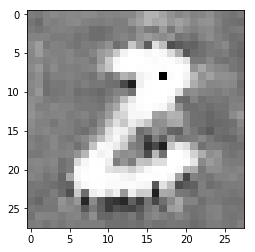

label tensor(1)
Iteration: 200
Discriminator Cost tensor(0.1400)
Generator Cost tensor(0.1255)


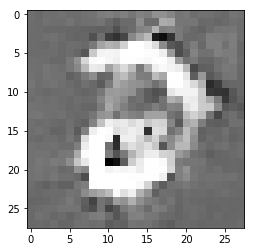

label tensor(8)
Iteration: 300
Discriminator Cost tensor(0.1137)
Generator Cost tensor(0.1607)


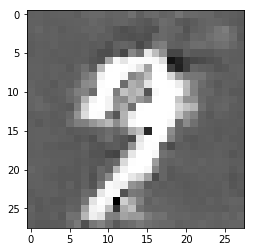

label tensor(7)
Iteration: 400
Discriminator Cost tensor(0.1330)
Generator Cost tensor(0.1341)


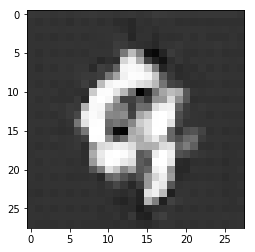

KeyboardInterrupt: 

In [17]:
train_gan(generator, discriminator, image_loader, 10, num_train_batches=num_train_batches)